In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import os
import gc

from shared.utils import *
from shared.local_path import *

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Data Preprocessing
## Audio Data

In [2]:
label = []
filepath = []

for classes in os.listdir(AUDIO_PATH):
    for file in os.listdir(os.path.join(AUDIO_PATH, classes)):
        file_path = os.path.join(AUDIO_PATH, classes, file)

        filepath.append(file_path)
        label.append(classes)

audio = pd.DataFrame({
    'filepath': filepath,
    'label': label,
})

del filepath, label

audio.head()

,filepath,label
0,E:\\Skripsi\data\audio\angry\03-01-05-01-01-01...,angry
1,E:\\Skripsi\data\audio\angry\03-01-05-01-01-01...,angry
2,E:\\Skripsi\data\audio\angry\03-01-05-01-01-01...,angry
3,E:\\Skripsi\data\audio\angry\03-01-05-01-01-01...,angry
4,E:\\Skripsi\data\audio\angry\03-01-05-01-01-01...,angry


In [3]:
le = LabelEncoder()
le.fit(audio['label'])
audio['label_encoded'] = le.transform(audio['label'])
num_classes = len(le.classes_)

In [4]:
with tf.device('/GPU:0'):
    audio['data'] = audio.filepath.apply(preprocess_audio)
    audio = audio.sample(frac=1).reset_index(drop=True)

C:\ProgramData\miniconda3\envs\tf\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=96
  warnings.warn(
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1152
  warnings.warn(
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1472
  warnings.warn(
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1056
  warnings.warn(
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1792
  warnings.warn(
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=320
  warnings.w

In [5]:
x_audio = np.stack(audio['data'].values)
y_audio = audio['label_encoded'].values
print(x_audio.shape)
del audio

(27406, 128, 110, 3)


In [6]:
x_audio_train, x_temp, y_audio_train, y_temp = train_test_split(
    x_audio, y_audio, test_size=0.3, random_state=100,
)

x_audio_val, x_audio_test, y_audio_val, y_audio_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=222,
)

del x_audio, y_audio
print(x_audio_train.shape)
print(x_audio_train.shape[0] == len(y_audio_train))

(19184, 128, 110, 3)
True


# Modeling
## Model Image

In [7]:
base_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top=False,
    input_tensor=tf.keras.layers.Input(shape=(128, 110, 3)),
)

for layer in base_model.layers:
    layer.trainable = False

In [8]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [9]:
plot_model(model, show_shapes=True)

In [10]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    mode='min',
    # start_from_epoch=2,
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('model', 'best_model.keras'),
    verbose=2,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.2,
                                                    min_lr=1e-6,
                                                    patience=3,
                                                    mode='min'
                                                    )

In [11]:
history = model.fit(
    x_audio_train,
    y_audio_train,
    validation_data=(x_audio_val, y_audio_val),
    callbacks=[lr_scheduler],
    epochs=50,
    verbose=2,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(x_audio_train) // BATCH_SIZE,
    validation_steps=len(x_audio_val) // BATCH_SIZE,
)


Epoch 1/50
299/299 - 33s - loss: 1.3877 - accuracy: 0.4777 - val_loss: 1.1811 - val_accuracy: 0.5540 - lr: 0.0010 - 33s/epoch - 110ms/step
Epoch 2/50
299/299 - 26s - loss: 1.1518 - accuracy: 0.5543 - val_loss: 1.1815 - val_accuracy: 0.5337 - lr: 0.0010 - 26s/epoch - 86ms/step
Epoch 3/50
299/299 - 24s - loss: 1.0527 - accuracy: 0.5956 - val_loss: 1.0770 - val_accuracy: 0.5913 - lr: 0.0010 - 24s/epoch - 81ms/step
Epoch 4/50
299/299 - 24s - loss: 0.9784 - accuracy: 0.6260 - val_loss: 1.0559 - val_accuracy: 0.5867 - lr: 0.0010 - 24s/epoch - 82ms/step
Epoch 5/50
299/299 - 24s - loss: 0.9120 - accuracy: 0.6519 - val_loss: 1.0222 - val_accuracy: 0.6042 - lr: 0.0010 - 24s/epoch - 81ms/step
Epoch 6/50
299/299 - 24s - loss: 0.8457 - accuracy: 0.6797 - val_loss: 0.9936 - val_accuracy: 0.6208 - lr: 0.0010 - 24s/epoch - 81ms/step
Epoch 7/50
299/299 - 25s - loss: 0.7875 - accuracy: 0.7079 - val_loss: 1.0213 - val_accuracy: 0.6208 - lr: 0.0010 - 25s/epoch - 82ms/step
Epoch 8/50
299/299 - 25s - loss: 

# Evaluate Model
## Using the model.evaluate
### using test set

In [12]:
print(model.evaluate(x_audio_test, y_audio_test, batch_size=BATCH_SIZE, steps=len(x_audio_test) // BATCH_SIZE))

128/128 [==============================] - 6s 36ms/step - loss: 0.8059 - accuracy: 0.7971
[0.8058531284332275, 0.797119140625]


### Using validation set

In [13]:
print(model.evaluate(x_audio_val, y_audio_val, batch_size=BATCH_SIZE, steps=len(x_audio_val) // BATCH_SIZE))

128/128 [==============================] - 5s 35ms/step - loss: 0.8005 - accuracy: 0.7964
[0.8005247712135315, 0.79638671875]


In [14]:
def plot_and_save(metric_name, history, ylabel, filename):
    plt.figure()
    plt.plot(history.history[metric_name], label=f'Train {ylabel}')
    if f'val_{metric_name}' in history.history:
        plt.plot(history.history[f'val_{metric_name}'], label=f'Val {ylabel}')
    plt.title(f'{ylabel} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

In [15]:
plot_and_save('loss', history, 'Audio_Loss', 'Audio_loss_plot-nolr.png')
plot_and_save('accuracy', history, 'Audio Classification Accuracy', 'Audio_class_accuracy_plot-nolr.png')

In [16]:
predictions = model.predict(x_audio_test)
predictions = np.argmax(predictions, axis=1)

129/129 [==============================] - 5s 39ms/step


In [17]:
classes = [x for x in os.listdir(AUDIO_PATH)]
print(classes)

['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


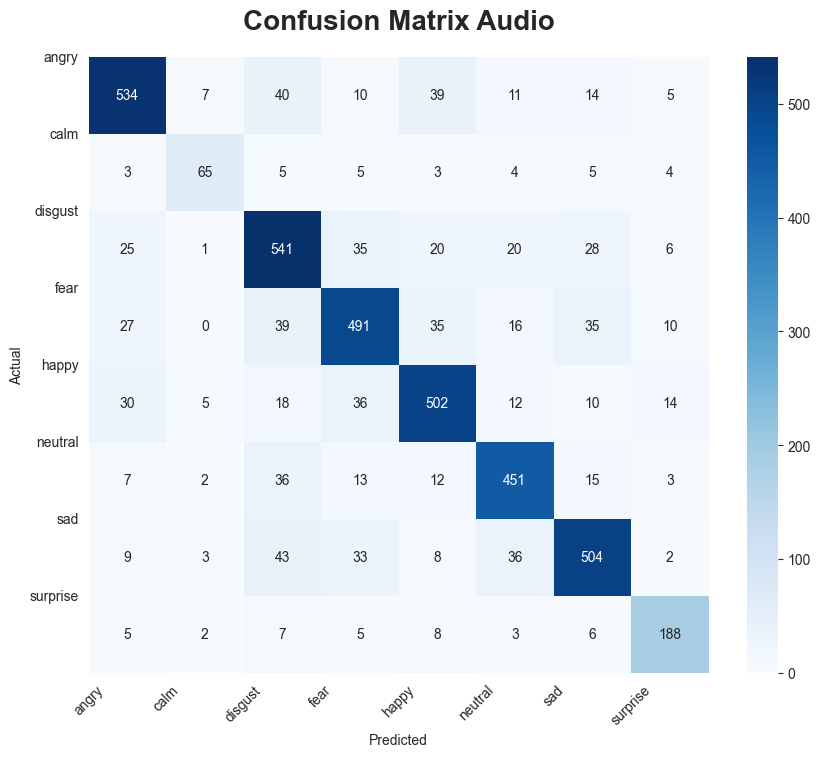

In [18]:
cm = confusion_matrix(y_audio_test, predictions)

plt.figure(figsize=(10, 8))  # Set the figure size if needed
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix Audio', pad=20, fontsize=20, fontweight="bold")
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Set ticks for the x and y axes using class names
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=range(len(classes)), labels=classes, rotation=0)
plt.savefig('confusion_matrix_audio.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
print(classification_report(predictions, y_audio_test))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       640
           1       0.69      0.76      0.73        85
           2       0.80      0.74      0.77       729
           3       0.75      0.78      0.77       628
           4       0.80      0.80      0.80       627
           5       0.84      0.82      0.83       553
           6       0.79      0.82      0.80       617
           7       0.84      0.81      0.82       232

    accuracy                           0.80      4111
   macro avg       0.79      0.80      0.79      4111
weighted avg       0.80      0.80      0.80      4111



In [ ]:
model.save('model_sc4_t3_audio.h5')